## Importing the libraries

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Data Preprocessing

### Load data as transactions

In [12]:
with open('Market_Basket_Optimisation.csv', 'r') as f:
    transactions = [list(filter(None, line.strip().split(','))) for line in f if line.strip()]

### Create a dataframe of transactions (one-hot encoding)


In [13]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit_transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)


## Eclat Implementation

In [14]:
from collections import defaultdict
from itertools import combinations

In [15]:
def eclat(prefix, items, min_support, freq_itemsets, tidset_dict):
    while items:
        i, itids = items.pop()
        new_prefix = prefix + [i]
        freq_itemsets[frozenset(new_prefix)] = len(itids)
        # Extension step: find items occurring with current item
        candidates = []
        for j, jtids in items:
            tids = itids & jtids
            if len(tids) >= min_support:
                candidates.append((j, tids))
        eclat(new_prefix, candidates, min_support, freq_itemsets, tidset_dict)


### Convert to tidset representation


In [16]:
tidset_dict = defaultdict(set)
for tid, row in df.iterrows():
    for item in df.columns[row]:
        tidset_dict[item].add(tid)

min_support = int(0.02 * len(df))  # Example: Minimum support = 2%
freq_itemsets = dict()
items = [(item, tids) for item, tids in tidset_dict.items() if len(tids) >= min_support]
eclat([], items, min_support, freq_itemsets, tidset_dict)


## Extract Association Rules


### To extract rules from frequent itemsets:

In [17]:
def generate_rules(freq_itemsets, min_confidence=0.2):
    rules = []
    for itemset in freq_itemsets:
        if len(itemset) > 1:
            support = freq_itemsets[itemset] / len(df)
            for i in range(1, len(itemset)):
                for antecedent in combinations(itemset, i):
                    antecedent = frozenset(antecedent)
                    consequent = itemset - antecedent
                    if consequent:
                        conf = freq_itemsets[itemset] / freq_itemsets.get(antecedent, 1)
                        if conf >= min_confidence:
                            rules.append({
                                'antecedent': set(antecedent),
                                'consequent': set(consequent),
                                'support': support,
                                'confidence': conf
                            })
    return rules

rules = generate_rules(freq_itemsets, min_confidence=0.2)



### Sort and show top 10 rules by confidence


In [18]:
rules_sorted = sorted(rules, key=lambda x: (x['confidence'], x['support']), reverse=True)
for r in rules_sorted[:10]:
    print(f"{r['antecedent']} => {r['consequent']} [Support: {r['support']:.3f}, Confidence: {r['confidence']:.3f}]")

{'soup'} => {'mineral water'} [Support: 0.023, Confidence: 0.456]
{'olive oil'} => {'mineral water'} [Support: 0.028, Confidence: 0.419]
{'ground beef'} => {'mineral water'} [Support: 0.041, Confidence: 0.417]
{'ground beef'} => {'spaghetti'} [Support: 0.039, Confidence: 0.399]
{'cooking oil'} => {'mineral water'} [Support: 0.020, Confidence: 0.394]
{'chicken'} => {'mineral water'} [Support: 0.023, Confidence: 0.380]
{'frozen vegetables'} => {'mineral water'} [Support: 0.036, Confidence: 0.375]
{'milk'} => {'mineral water'} [Support: 0.048, Confidence: 0.370]
{'tomatoes'} => {'mineral water'} [Support: 0.024, Confidence: 0.357]
{'pancakes'} => {'mineral water'} [Support: 0.034, Confidence: 0.355]


## Top 10 Association Rules

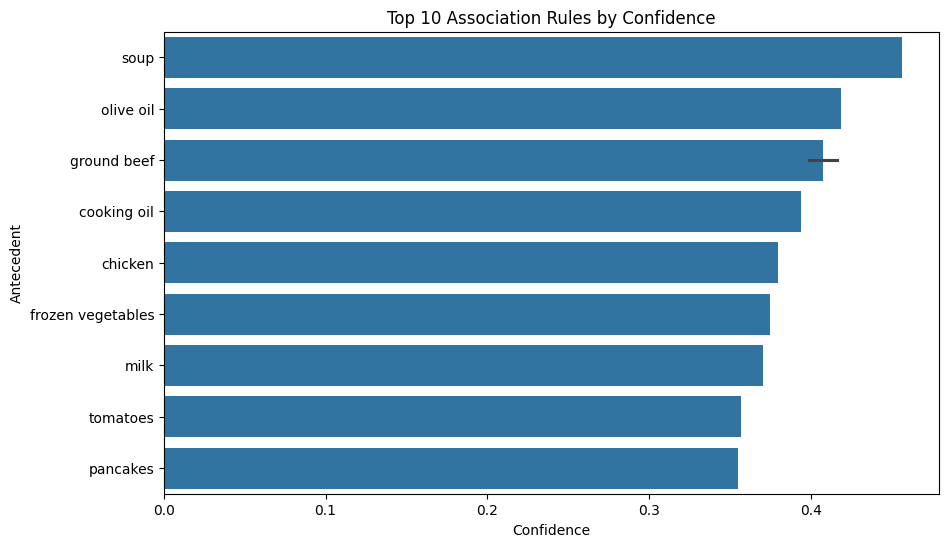

In [ ]:
def plot_rules(rules):
    df_rules = pd.DataFrame(rules)
    df_rules['antecedent'] = df_rules['antecedent'].apply(lambda x: ', '.join(x))
    df_rules['consequent'] = df_rules['consequent'].apply(lambda x: ', '.join(x))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='confidence', y='antecedent', data=df_rules.sort_values(by='confidence', ascending=False).head(10))
    plt.title('Top 10 Association Rules by Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Antecedent')
    plt.show()
plot_rules(rules_sorted)